In [1]:
import os.path
import random
import uuid
import PIL.Image
import tensorflow as tf
from PIL.Image import Image
from PIL.Image import Resampling
from tensorflow import keras
from keras import layers
import pickle

In [2]:
tf.__version__

'2.9.2'

In [3]:
print("Physical devices: ", tf.config.list_physical_devices())

Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

Metal device set to: Apple M1 Pro


2022-08-24 16:44:38.152906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-24 16:44:38.153127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# create a GAN class with the tensorflow structure
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
# create an image saver
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            # img.save("generated_img_%03d_%d.png" % (epoch, i))

In [8]:
def create_model(faces_dir, weights_dir='', epochs=2):
    # images preprocessing
    dataset = keras.preprocessing.image_dataset_from_directory(
        faces_dir, label_mode=None, image_size=(64, 64), batch_size=2
    )
    dataset = dataset.map(lambda x: x / 255.0)

    print('dataset length :', len(dataset))

    # fit the models
    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss_fn=keras.losses.BinaryCrossentropy(),
    )

    gan.fit(
        dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
    )

    with open(os.path.join(weights_dir, "weights.txt"), "wb") as fp:  # Pickling
        pickle.dump(gan.weights, fp)

In [9]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(color_filter(img), box=(i%cols*w, i//cols*h))

    return grid

In [10]:
def color_filter(img: Image):
    rdiv = random.randrange(1, 3)
    gdiv = random.randrange(1, 3)
    bdiv = random.randrange(1, 3)

    for px in range(img.width):
        for py in range(img.height):
            r, g, b = img.getpixel((px, py))
            r = r//rdiv
            g = g//gdiv
            b = b//bdiv
            img.putpixel((px, py), (r, g, b))

    return img

In [11]:
def generate_faces(faces_nbr, model_dir='weights.txt', faces_dir='faces'):
    gan_2 = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan_2.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss_fn=keras.losses.BinaryCrossentropy(),
    )
    with open(model_dir, "rb") as fp:
        gan_2.set_weights(pickle.load(fp))

    random_latent_vectors = tf.random.normal(shape=(128, 128))
    generated_images = gan_2.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()

    images = []

    for i in range(faces_nbr ** 2):
        img: Image = keras.preprocessing.image.array_to_img(generated_images[i])
        img.resize((1024, 1024), resample=Resampling.BOX)
        images.append(img)

    file_name = str(uuid.uuid4())
    img = image_grid(images, faces_nbr, faces_nbr)
    img.save(os.path.join(faces_dir, file_name + ".png"))

    return img

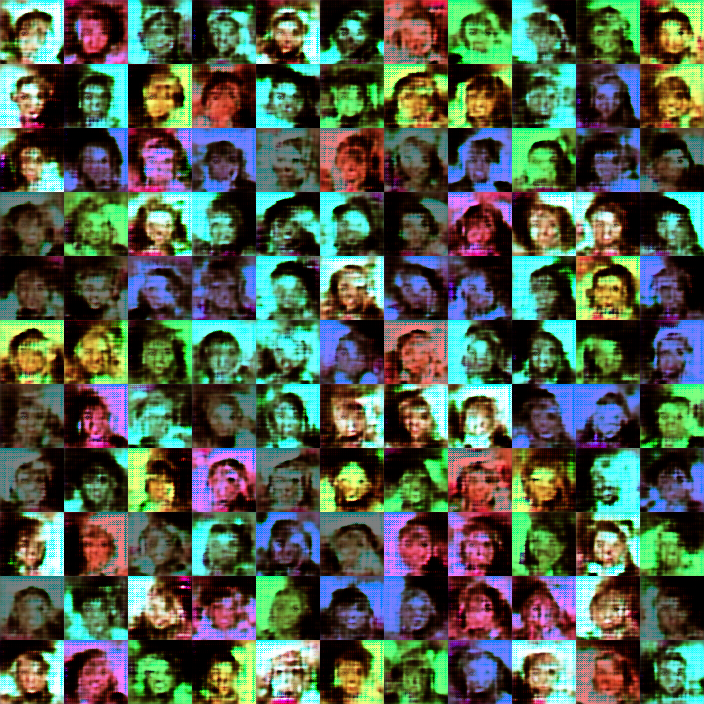

In [12]:
generate_faces(11)